In [63]:
%load_ext tensorboard

In [202]:
#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

In [60]:
#load dataset
df=pd.read_csv("../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[len(df)-(30*15):]

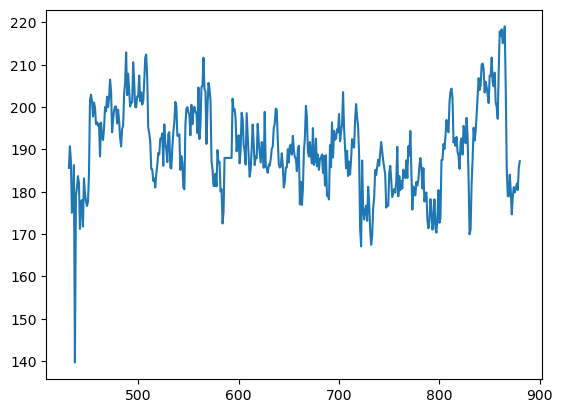

In [62]:
plt.plot(df)

In [75]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.values.reshape(-1,1))

In [86]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

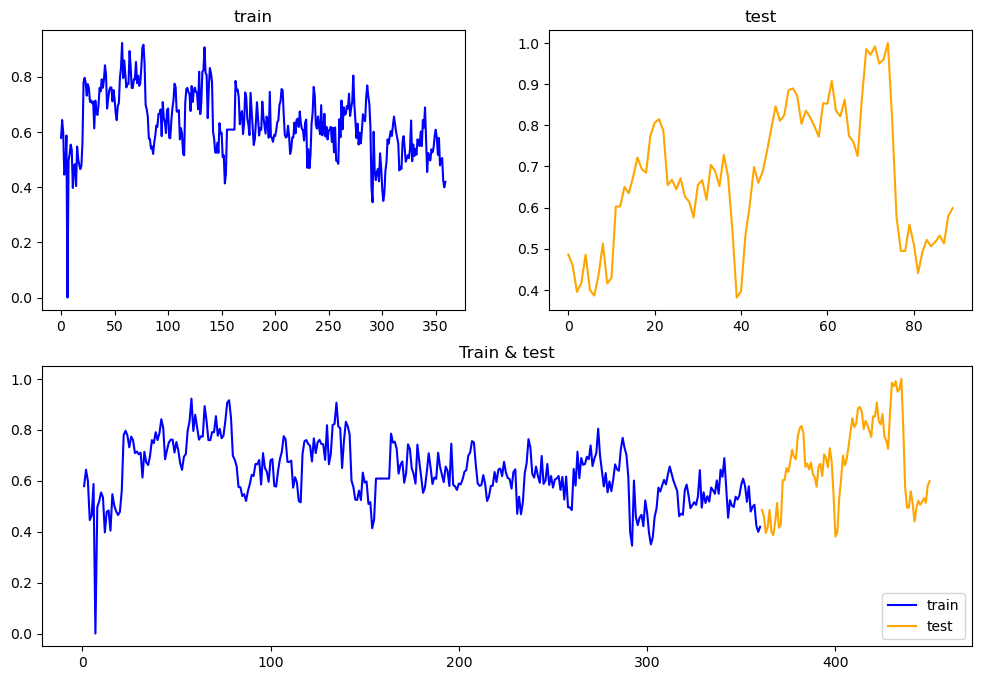

In [175]:
#plotting train, test and both
def plottraintest():
    fig =plt.figure(figsize=(12,8))
    ax=fig.add_subplot(2,2,1)
    ax.plot(train, c="blue")
    ax.set_title("train")
    ax=fig.add_subplot(2,2,2)
    ax.plot(test, c="orange")
    ax.set_title("test")
    ax=fig.add_subplot(2,1,2)
    temp=np.array(list(map(list, zip(train.flatten(), range(1,len(train)+1)))))
    ax.plot(temp[:,1], temp[:,0], c="blue", label="train")
    temp=np.array(list(map(list, zip(test.flatten(), range(len(train)+1,len(train)+len(test)+1)))))
    ax.plot(temp[:,1], temp[:,0], c="orange", label="test")
    ax.legend(loc="lower right")
    ax.set_title("Train & test")
plottraintest()

In [196]:
# reshape into X=t and Y=t+1

def lag(dataset, t=1):
    '''Default t=1'''
    dataX, dataY = [], []
    for i in range(len(dataset)-t-1):
        a = dataset[i:(i+t), 0]
        dataX.append(a)
        dataY.append(dataset[i + t, 0])
    return np.array(dataX), np.array(dataY)

t=1
trainX, trainY = lag(train)
testX, testY = lag(test)

In [197]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [198]:
#create model
def getmodel_compile():
    model=keras.Sequential([
        keras.layers.LSTM(4, input_shape=(1, t)),           #4 hidden layer will be great for test, i guess?
        keras.layers.Dense(1)])                             #regression
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [199]:
model=getmodel_compile()
model.fit(trainX, trainY, epochs=50, batch_size=32, verbose=1)

Epoch 1/100
358/358 - 8s - loss: 0.1981 - 8s/epoch - 22ms/step
Epoch 2/100
358/358 - 1s - loss: 0.0110 - 1s/epoch - 4ms/step
Epoch 3/100
358/358 - 1s - loss: 0.0100 - 1s/epoch - 4ms/step
Epoch 4/100
358/358 - 1s - loss: 0.0095 - 1s/epoch - 3ms/step
Epoch 5/100
358/358 - 1s - loss: 0.0092 - 1s/epoch - 3ms/step
Epoch 6/100
358/358 - 1s - loss: 0.0088 - 1s/epoch - 3ms/step
Epoch 7/100
358/358 - 1s - loss: 0.0084 - 1s/epoch - 4ms/step
Epoch 8/100
358/358 - 1s - loss: 0.0080 - 1s/epoch - 4ms/step
Epoch 9/100
358/358 - 1s - loss: 0.0078 - 1s/epoch - 4ms/step
Epoch 10/100
358/358 - 1s - loss: 0.0074 - 1s/epoch - 4ms/step
Epoch 11/100
358/358 - 1s - loss: 0.0071 - 1s/epoch - 4ms/step
Epoch 12/100
358/358 - 1s - loss: 0.0068 - 1s/epoch - 3ms/step
Epoch 13/100
358/358 - 1s - loss: 0.0066 - 1s/epoch - 3ms/step
Epoch 14/100
358/358 - 1s - loss: 0.0064 - 1s/epoch - 4ms/step
Epoch 15/100
358/358 - 1s - loss: 0.0061 - 1s/epoch - 3ms/step
Epoch 16/100
358/358 - 1s - loss: 0.0059 - 1s/epoch - 3ms/step


In [204]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)

3/3 [==============================] - 0s 4ms/step


In [223]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY).reshape(-1,1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY).reshape(-1,1)

3/3 [==============================] - 0s 5ms/step
Train Score: 364999010287845780750336.00 RMSE
Test Score: 9563222317642968.00 RMSE


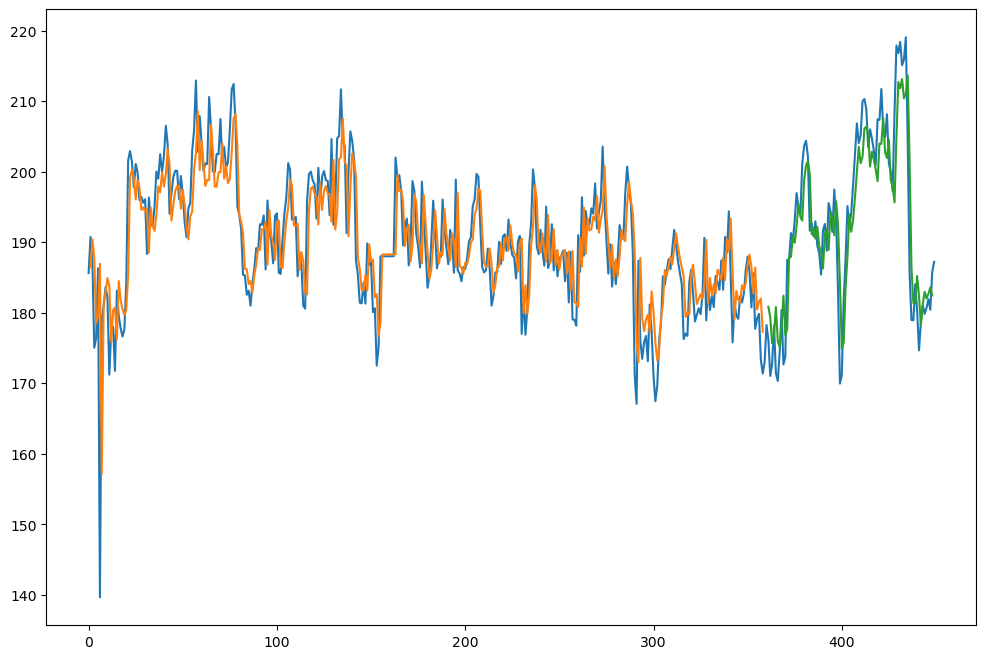

In [229]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[t:len(trainPredict)+t, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(t*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
ax.plot(scaler.inverse_transform(df))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)